# Coding Challenge #2 - Basic Weather Map

In this challenge, you'll make a basic weather map. Using the ```xarray``` package, you'll learn how to read gridded data from a *NetCDF* file and extract the information you want. Using ```matplotlib``` and ```cartopy```, you'll plot this data on a basemap to give it geographical context. We'll also explore colormaps and learn how to properly position a colorbar next to a map.

### Read data with xarray

[xarray](http://xarray.pydata.org/en/stable/) is a powerful python package designed for manipulating gridded datasets. It can easily read *NetCDF* - one of the most common file types for gridded weather data. It also has some support for *grib*, another common file type.  

For this demonstration, we have reanalysis data from ECMWF's ERA-5. This is valid at 00z on December 17, 2020 during the major winter storm that brought 15" of snow to State College and over 3 feet in Binghamton, NY. You're welcome to use this data, but you're encouraged to download your own for a weather event of interest: https://cds.climate.copernicus.eu/cdsapp#!/search?text=ERA5%20back%20extension&type=dataset  
Note that pressure-level variables and surface-level variables will need to be downloaded separately.

In [1]:
# It can be useful to look at the NetCDF file before you try to open it, or if you get errors when attempting to open it (you must have NCO installed)
# You can run this command on the terminal (without the leading !)
! ncdump -h ./data/era5-plvl-2020121700.nc

netcdf era5-plvl-2020121700 {
dimensions:
	longitude = 321 ;
	latitude = 241 ;
	level = 5 ;
	time = 1 ;
variables:
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:long_name = "longitude" ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:long_name = "latitude" ;
	int level(level) ;
		level:units = "millibars" ;
		level:long_name = "pressure_level" ;
	int time(time) ;
		time:units = "hours since 1900-01-01 00:00:00.0" ;
		time:long_name = "time" ;
		time:calendar = "gregorian" ;
	short z(time, level, latitude, longitude) ;
		z:scale_factor = 1.66071417501488 ;
		z:add_offset = 52915.8161272875 ;
		z:_FillValue = -32767s ;
		z:missing_value = -32767s ;
		z:units = "m**2 s**-2" ;
		z:long_name = "Geopotential" ;
		z:standard_name = "geopotential" ;
	short t(time, level, latitude, longitude) ;
		t:scale_factor = 0.00153993972681225 ;
		t:add_offset = 257.936089160996 ;
		t:_FillValue = -32767s ;
		t:missing_value = -32767s ;
		t:uni

In [2]:
import numpy as np
from datetime import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.units import units

First, we'll open the file as an xarray dataset by using xarray's ```open_dataset()``` function.  

You'll see that `xarray.Dataset` objects have dimensions, coordinates, data variables, and attributes. These should be fairly self-explanatory. It's typical for weather data to have 4 or 5 dimensions - time, atmospheric level, latitude, longitude, and sometimes member (for ensemble data). The data variables are multi-dimension arrays that are a function of one or more of the dataset's dimensions. You can see here that our data variables are 4-D arrays.

In [3]:
xr.open_dataset('./data/era5-plvl-2020121700.nc')

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 5, longitude: 321, time: 1)
Coordinates:
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... -50.5 -50.25 -50.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 10.5 10.25 10.0
  * level      (level) int32 250 500 700 850 1000
  * time       (time) datetime64[ns] 2020-12-17
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-22 21:23:59 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Since the pressure-level data and surface-level data are in separate files, I'll open them as one xarray dataset to make it easier to deal with for this example.

You'll see that not all data variables are a function of pressure level (the surface variables, by definition, don't have a pressure level). This is why the data was in separate files to begin with -- while xarray can deal with this, NetCDFs get a bit funky when you have a variable that isn't a function of every dimension.

In [4]:
ds = xr.open_mfdataset(['./data/era5-plvl-2020121700.nc', './data/era5-sfc-2020121700.nc'])
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 5, longitude: 321, time: 1)
Coordinates:
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... -50.5 -50.25 -50.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 2020-12-17
  * level      (level) int32 250 500 700 850 1000
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    msl        (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    mtpr       (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    ptype      (time, latitude, longitude) float32 dask.array<chunksize=(1, 241, 321), meta=np.ndarray>
    z          (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 5, 241, 321), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 5, 241, 321), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 5, 241, 321), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 5, 241, 321), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-22 21:23:59 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

We're now ready to parse the xarray dataset to obtain the information we'll need to make a basic plot. It's useful to grab the "valid time" of the weather data we're plotting, as it will be displayed in some form on the title of our map. Our dataset has a time dimension, but as the dataset only contains one time step, we can eliminate it. Often, our datasets will have a time dimension of some length greater than 1, so to make a plot, we'll need data at just one time step. We can use the xarray dataset's `sel()` method to select data based on dimension values. The method accepts dimension names as keyword arguments, so we can select data by passing dimension values. http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html

In [5]:
# Grab the valid time of the analysis - use pandas function to_datetime() to convert to datetime object (useful later)
valid = pd.to_datetime(ds.time.values[0])
# Eliminate the time dimension by selecting the valid time
ds = ds.sel(time=ds.time.values[0])
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 5, longitude: 321)
Coordinates:
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... -50.5 -50.25 -50.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 10.5 10.25 10.0
    time       datetime64[ns] 2020-12-17
  * level      (level) int32 250 500 700 850 1000
Data variables:
    u10        (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    v10        (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    d2m        (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    t2m        (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    msl        (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    mtpr       (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    ptype      (latitude, longitude) float32 dask.array<chunksize=(241, 321), meta=np.ndarray>
    z          (level, latitude, longitude) float32 dask.array<chunksize=(5, 241, 321), meta=np.ndarray>
    t          (level, latitude, longitude) float32 dask.array<chunksize=(5, 241, 321), meta=np.ndarray>
    u          (level, latitude, longitude) float32 dask.array<chunksize=(5, 241, 321), meta=np.ndarray>
    v          (level, latitude, longitude) float32 dask.array<chunksize=(5, 241, 321), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-22 21:23:59 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Now that the time dimension has been eliminated, we're ready to select data for plotting. To plot any 2-D field on a grid, we need x and y values (longitude and latitude, in this case). This will allow us to plot the data from this dataset on a base map.

In [6]:
# Grab latitude and longitude arrays we'll need for plotting
lon = ds.longitude.values
lat = ds.latitude.values

For this example, I'll show how to make a plot of 850mb height and temperature. For this plot, we'll need data for the variables we wish to plot in the correct units. You can perform the unit conversions manually, however I prefer to use the [metpy](https://unidata.github.io/MetPy/latest/index.html) library to make life easier. Metpy is great for working with weather data and performing meteorological calculations, so I recommend learning how to leverage some of its capabilities (what I show here is only scratching the surface!).  

To grab the data, we'll once again use the `sel()` method to extract geopotential and temperature data. This is necessary because these variables are a function of pressure level (so you could select data at any other pressure level if you desired), and we need to eliminate that dimension in order to plot. I'll go ahead and assign units using metpy's unit support to prepare for the necessary unit conversions.

In [7]:
# Select 850mb height and temperature data
# Assign units to make conversions easy
z850 = ds.sel(level=850).z.values/9.80665 * units.m # divide by g to convert geopotential to height (m)
t850 = ds.sel(level=850).t.values * units.kelvin

# We see that the arrays now have a units attribute
t850.units

<Unit('kelvin')>

In [8]:
# Convert height to decameters and temperature to degrees celsius
z850 = z850.to('dam')
t850 = t850.to('degC')
t850.units

<Unit('degree_Celsius')>

### Cartopy Plot Demo

Now that we have the data we need in the correct units, it's time to make the weather map! To make the data meaningful, we need to plot it on a base map. To do this, we'll use the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package - designed for plotting geospatial data.

The first step in creating any plot is to set up the matplotlib figure and add axes to plot our data on. Instead of adding a regular matplotlib axes object, we'll add a cartopy axis. When we create this axis, we can specify the map projection - there are [many to choose from](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html). We'll also specify a map extent, which controls the visible map extent. This is useful, because if we are plotting data in North America, we don't need a map of the entire globe.

Next, we'll want to add some features to our base map using the `add_feature()` method. Cartopy has many common borders "baked-in", but you can also add any custom shape file you like (such as roads, counties, etc).

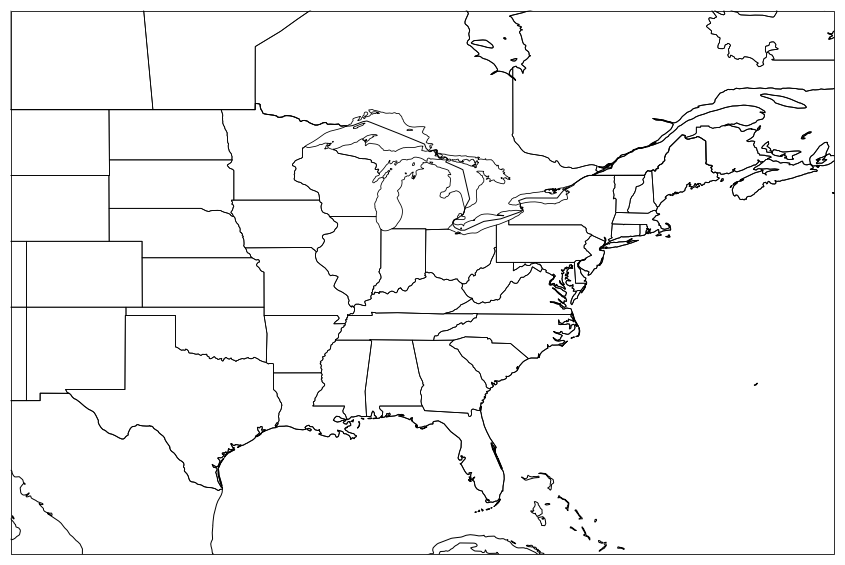

In [9]:
# Create the figure
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree()) # create the axis and specify the map projection
ax.set_extent([-110,-60,22,55], crs=ccrs.PlateCarree()) # set map extent over the eastern US

# Add land, state, and country borders
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8) # specify resolution as '110m' (low), '50m', or '10m' (high)

plt.show()

This base map looks good for now, so let's plot some data! Since cartopy is built around matplotlib, we can call our regular matplotlib plotting functions to plot contours, lines, etc. The only difference is we need to pass the `transform` keyword argument, which tells cartopy what projection our data is in (so it can perform the necessary transformations). For most weather data that is on a regular latitude/longitude grid (such as this), the transform value will always be `caropy.crs.PlateCarree()`.

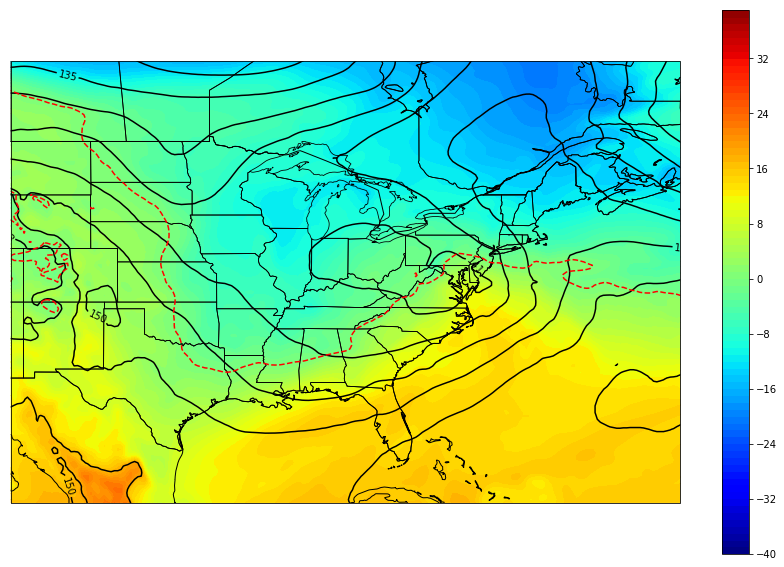

In [10]:
# Map creation
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110,-60,22,55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8)

# Plot height contours using standard contours with contour labels
cont = ax.contour(lon, lat, z850.data, levels=np.arange(90,210,3), colors='black', transform=ccrs.PlateCarree())
plt.clabel(cont, fmt='%d')

# Plot temperature filled contours
contf = ax.contourf(lon, lat, t850.data, levels=np.arange(-40,40,1), cmap='jet', vmin=-40, vmax=40, transform=ccrs.PlateCarree())

# Add a dashed red contour at 0C
ax.contour(lon, lat, t850.data, levels=[0], colors='red', linestyles='--', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(contf)

plt.show()

The weather map is starting to look useful - we now have 850mb height contours, 850mb temperature filled contours, and an 850mb freezing line. We have a colorbar to give the filled contours some context, but it's way too big and its size seems to be independent of the plot. 

To fix the colorbar to the size of the plot, an easy fix is to create an inset axes. This will be specified as a percentage of the width and height of the plot, and can be anchored to any corner. For now, we'll anchor it to the lower right corner of the plot, which will place the colorbar on the right side of the plot.

As a final touch, we should add some descriptive titles. Now that the valid time has been converted into a datetime object, it's easy to format it as a date string. Check out the [python strftime reference](https://strftime.org) if you need help understanding the date format string.

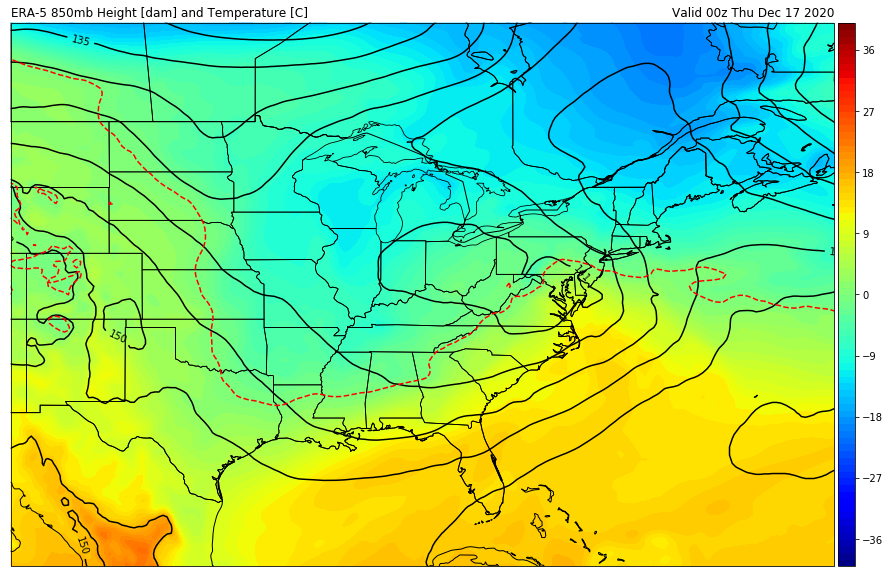

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset axes from matplotlib toolkit

# Map creation
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-110,-60,22,55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.8)

# Plot height contours using standard contours with contour labels
cont = ax.contour(lon, lat, z850.data, levels=np.arange(90,210,3), colors='black', transform=ccrs.PlateCarree())
plt.clabel(cont, fmt='%d')

# Plot temperature filled contours
contf = ax.contourf(lon, lat, t850.data, levels=np.arange(-40,41,1), cmap='jet', vmin=-40, vmax=40, transform=ccrs.PlateCarree())

# Add a dashed red contour at 0C
ax.contour(lon, lat, t850.data, levels=[0], colors='red', linestyles='--', transform=ccrs.PlateCarree())

# Create the colorbar axes - width of 2% of the map and height of 100%
cb_ax = inset_axes(ax, width='2%', height='100%', loc='lower right',
                   bbox_to_anchor=(.025,0,1,1), bbox_transform=ax.transAxes, borderpad=0)
plt.colorbar(contf, cax=cb_ax)

# Titles
ax.set_title('ERA-5 850mb Height [dam] and Temperature [C]', loc='left')
ax.set_title('Valid '+valid.strftime('%Hz %a %b %d %Y'), loc='right')

plt.show()

# The Challenge

For this challenge, you'll produce your own weather map like the example above using weather data of your choice. You may use the example dataset, although I'd encourage you to download your own data for a notable weather event.

The weather map should have:
1. At least one contoured variable (using `contour()`)
2. One filled contour variable (using `contourf()` or `pcolormesh()`)
3. A base map
4. Descriptive title(s)
5. A colorbar

Optionally, you might want to explore:
1. Plotting streamlines or wind barbs (use `streamplot()` or `barbs()`)
2. Custom colormaps or colormap normalizations
3. Plotting high and low pressure centers

The [Unidata Python Gallery](https://unidata.github.io/python-gallery/examples/index.html) is an excellent resource and has many examples of the various plots you can create using matplotlib, cartopy, and metpy. Google searches can also lead you to many useful examples!